## **Compute and fit galaxy profiles in IllustrisTNG**

This notebook contains code for computing a galaxy profile from the IllustrisTNG simulations and then fitting it with the Diemer-Kravstov 2014 fitting formula. In addition to using the $\texttt{splashback_tools}$ code in this repository, it also uses the $\texttt{illustris_python}$ package which is available at: https://github.com/illustristng/illustris_python

In [1]:
from splashback_tools.profiles import fit_profs, calc_profs, mc_chain
import illustris_python as il
import numpy as np
import os
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'   # Makes inline plots look better (at least on mac)

from itertools import tee
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

#### **Load simulation data**

First we need to load the relevant python packages, as well as the IllustrisTNG simulation data. In this case, I have already downloaded the snapshot 99 group catalog from the TNG-300_3 simulation and saved it in $\texttt{sample_data/TNG300_3/}$. 


Snapshot 99 corresponds to redshift $z=0$ (i.e. present day). The group catalog contains information such as the mass and location of clusters, as well as that of galaxies (subhalos). The remainder of the simulation information is stored in the snapshot files which contain all of the particle locations and are much larger. We use three functions from the **illustris_python** package

* **il.groupcat.loadHeader:** loads the header file which contains general information about the simulation you are considering. (If you want to see everything contained in the header, you can execute "print(header)")
* **il.groupcat.loadHalos:** loads the halo catalog which contains various halo quantities (listed here: https://www.tng-project.org/data/docs/specifications/#sec2a). In this case I just load their GroupPos, M200m, and R200m. The GroupPos is defined as the center of the most gravitationally bound particle in the halo.
* **il.groupcat.loadSubhalos:** loads the subhalo catalog which contains information about the subhalos (galaxies). All available quantities are listed here: https://www.tng-project.org/data/docs/specifications/#sec2b. Here I load the SubhaloPos, SubhaloFlag, and SubhaloMassType. SubhaloFlag just indicates some subhalos that should generally be excluded from an analysis. SubhaloMassType is a $N_{\rm subhalo}\times 6$ dimensional array containing the mass of each particle type in the subhalo. I use this to place a cut on the stellar mass of the subhalos we use.

In [2]:
# Specify simulation and snapshot here
snapshot_ind = 99
base_path    = 'sample_data/TNG300_1'
print("Loading Header:")
header = il.groupcat.loadHeader(base_path, snapshot_ind)
redshift = header['Redshift']
scale_factor = 1/(1+redshift)
boxsize = header['BoxSize']/1000*scale_factor #  Mpc/h

# Load group
print("Loading Group Catalog:")
halo_cat_fields = ['GroupPos', 'Group_M_Mean200',  'Group_R_Mean200']
halo_cat = il.groupcat.loadHalos(base_path, snapshot_ind, halo_cat_fields)


print("Loading Subhalo Catalog")
fields = ['SubhaloPos', 'SubhaloMassType', 'SubhaloFlag']
subhalo_cat = il.groupcat.loadSubhalos(base_path, snapshot_ind, fields)

Loading Header:
Loading Group Catalog:
Loading Subhalo Catalog


#### **Compute Profiles**

Now we can use the functions from $\texttt{splashback_tools}$ to compute some density profiles. The profile calculation code needs us to specify the location of the cluster centers, as well as the location of the subhalos we are interested in analyzing.

##### **Load Clusters**
First we will select the clusters. In this case, I will select clusters using three mass bins  with $M_{\rm 200m}$ between $1e13.0$ and $1e14.5$ $M_{\odot}/h$. The clusters are stored in the halo catalogue.

In [3]:
def get_groups(halo_cat, min_mass, max_mass, N_groups=None):
    """
    Returns group centers, R200m, and M200m for groups in a mass [min_mass, max_mass].
    min_mass and max_mass must be specified in Msun/h. N_groups sets a maximum number of 
    groups/clusters to consider. For low mass groups, there can be many clusters between
    min_mass and max_mass, so setting N_groups can make things faster if you don't want
    to look at every cluster.
    """

    inds = np.where((halo_cat['Group_M_Mean200']*10**10 > min_mass) &
                    (halo_cat['Group_M_Mean200']*10**10 < max_mass))[0]

    if N_groups is not None:
        assert N_groups < len(inds), "Too many halos requested. Maximum for this mass range is {}".format(len(inds))

        inds = np.random.choice(inds, N_groups, replace=False)

    print("Number of halos selected in this mass bin: "+str(len(inds)))

    halo_centers = halo_cat['GroupPos'][inds]/1000*scale_factor      # Mpc/h
    halo_R200m = halo_cat['Group_R_Mean200'][inds]/1000*scale_factor # Mpc/h
    halo_M200m = halo_cat['Group_M_Mean200'][inds]*10**10            # Msun/h

    return {"pos": halo_centers, "R200m": halo_R200m, "M200m": halo_M200m}


lg_edges = np.linspace(13, 14.5, 7)
n_mbin = len(lg_edges) - 1
mbins = []
                 
for i, bounds in enumerate(pairwise(lg_edges)):
    l, r = bounds
    mbin = {}
    mbin['clusters'] = get_groups(halo_cat, 10**l, 10**r)
    mbin['bounds'] = f"{l} < $M_{{200m}}$ < {r}"
    mbin['color'] = (i/n_mbin, (n_mbin - i)/n_mbin, 1)
    mbins.append(mbin)

Number of halos selected in this mass bin: 1594
Number of halos selected in this mass bin: 977
Number of halos selected in this mass bin: 567
Number of halos selected in this mass bin: 325
Number of halos selected in this mass bin: 162
Number of halos selected in this mass bin: 63


In [4]:
redshift

2.220446049250313e-16

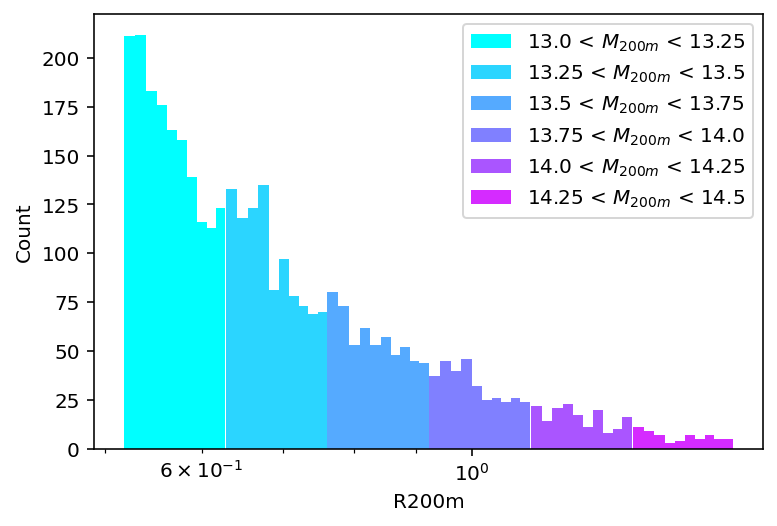

In [5]:
ax = plt.gca()
ax.set_xlabel('R200m')
ax.set_ylabel('Count')
ax.set_xscale('log')
for mbin in mbins:
    ax.hist(mbin['clusters']['R200m'], color = mbin['color'], label = mbin['bounds'])
    ax.legend()

##### **Load galaxies/subhalos**
Now we can select some galaxies. In this case, I will define galaxies as all subhalos that have mass greater than $10^8 \ M_{\rm sun}/h$ and have SubhaloFlag==1. I then want to load in the centers of all subhalos that satisfy these criteria.

In [6]:
def get_subhalos(subhalo_cat, min_stellar_mass=10**8):
    """
    Returns subhalo centers, spins, SFR, and photometrics for a fixed stellar mass cut
    """

    inds = np.where((subhalo_cat['SubhaloFlag']==1)  &
                    (subhalo_cat['SubhaloMassType'].T[4]*10**10>min_stellar_mass))[0]

    print("Total number of subhalos selected: "+str(len(inds)))
    return subhalo_cat['SubhaloPos'][inds]/1000*scale_factor      # Mpc/h

subhalos = get_subhalos(subhalo_cat)

Total number of subhalos selected: 528252


##### **Compute the galaxy radial density profile**

Having identified the centers of clusters we are interested in, as well as the centers of the galaxies we are interested in, we can now compute the density profile. All we need to do is specify the radial bins and some profile weighting options. For the binning I use 25 logarithmically spaced bins between $0.1$ and $7$ $R_{\rm 200m}$. Note that the binning can be in units of Mpc/h or R200m depending on if you specify $\texttt{R200m_arr}$ in the $\texttt{compute_avg_profiles}$ function. Some more details on the $\texttt{compute_avg_profiles}$ are listed below:

* The first two arguments are the centers of the clusters and the centers of the galaxies. 
* The third argument is the radial bins
* Boxsize must be given in the same units as the first two arguments. This is needed to account for periodic boundary conditions of the simulation
* R200m_arr: optional argument that if specified consists of the R200m values of the clusters selected and will bin the profiles in units of r/R200m.
* weights:   optional argument if you want to weight the galaxies/particles differently. Default is equal weighting.
* bin_stat:  optional argument specifying the statistic you want to apply over the individual profiles. The default is mean.
* return_mat: optional boolean that (if true) will also return an array consisting of the individual profiles for each cluster.


There are some additional arguments for this function and more details in the source code. The additional arguments are mostly relevant if you are interested in other profile types (e.g. velocity dispersion, etc.)

In [7]:
bins = np.logspace(-1, np.log10(7), 26)
for mbin in mbins:
    mbin['prof'] = calc_profs.compute_avg_profiles(mbin['clusters']['pos'], subhalos, bins,
                                                   boxsize = boxsize, R200m_arr = None,
                                                bin_stat="mean", return_mat = True, is_2d = True)


-> profiles will be binned in units of r


100%|██████████████████████████████████████████████████████████████████████████████| 1594/1594 [00:03<00:00, 448.92it/s]


Individual profiles computed. Now computing averaged profile!
-> profiles will be binned in units of r


100%|████████████████████████████████████████████████████████████████████████████████| 977/977 [00:01<00:00, 720.66it/s]


Individual profiles computed. Now computing averaged profile!
-> profiles will be binned in units of r


100%|████████████████████████████████████████████████████████████████████████████████| 567/567 [00:00<00:00, 832.59it/s]


Individual profiles computed. Now computing averaged profile!
-> profiles will be binned in units of r


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 988.41it/s]


Individual profiles computed. Now computing averaged profile!
-> profiles will be binned in units of r


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 968.72it/s]


Individual profiles computed. Now computing averaged profile!
-> profiles will be binned in units of r


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 870.86it/s]


Individual profiles computed. Now computing averaged profile!


##### **Plot the galaxy density profiles**

Before fitting the profiles, we can plot the density profiles to see if they make sense!

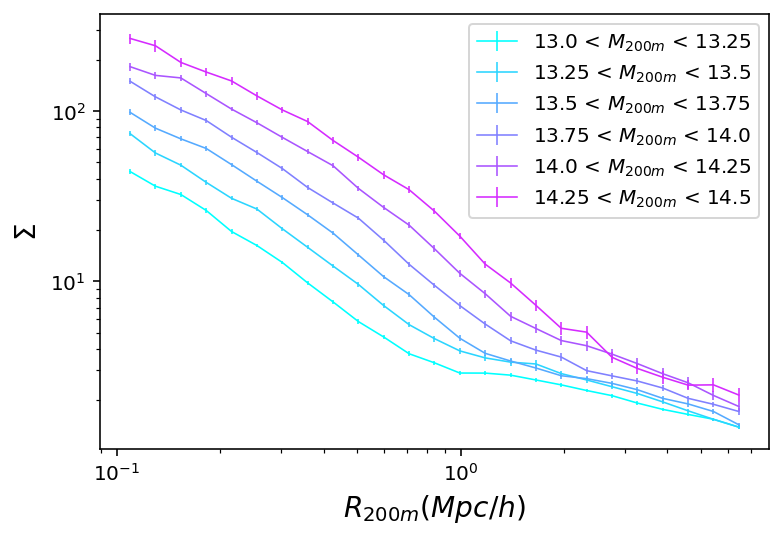

In [8]:
def log_ax(ax):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$\rho$", fontsize=14)
    ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)

def plot_profile(ax, prof, **kwargs):
    ax.errorbar(prof['r'], prof['dens'], yerr = np.sqrt(np.diag(prof['cov'])), linewidth = 0.8, **kwargs)

# Unstacked graph:
# fig, axs = plt.subplots(2, 3)
# fig.set_size_inches(15, 9)
# for ax, mbin in zip(axs.flatten(), mbins):
#     log_ax(ax)
#     ax.set_ylabel(r"$\Sigma$", fontsize=14)
#     ax.set_xlabel(r"$R_{200m}$", fontsize=14)
#     plot_profile(ax, mbin['prof'], color = 'teal')
#     ax.text(0.03, 0.05, mbin['bounds'], transform=ax.transAxes, fontsize=13)
    
# Stacked graph:
ax = plt.gca()
log_ax(ax)
ax.set_ylabel(r"$\Sigma$", fontsize=14)
ax.set_xlabel(r"$R_{200m} (Mpc/h)$", fontsize=14)
for mbin in mbins:
    plot_profile(ax, mbin['prof'], color = mbin['color'], label = mbin['bounds'])
    plt.legend()
plt.savefig("density_bars.png")

##### **Fit the galaxy density profiles**

Now we can fit the profiles and estimate the splashback radii. All we need to do is run the fit_profs.fit_DK_14 function with the profiles as input. The input for this function is a tuple of the form (r, rho, cov) so we define a function get_data_vec to format our measured profiles so that they are accepted by the fit_profs_fit_DK_14 function. The fitting function can save the output if a save directory is specified. In this case we do not save the output and instead analyze it in this notebook. 

You will also need to specify a `basepath` for Multinest to run the sampler. I have specified this as `/u/samgolds/lib/splashback_tools/splashback_tools/multinest_samples`, but it will need to be changed to a directory on the computer you are working on.

The output of the fit is an $11 \times N$ dimensional array where $N$ is the number of multinest samples (multinest determines this based on convergence criterion). The first 9 columns are the DK14 model parameters. The 10th column is the weights and the 11th is the negative log likelihood. So to find the best fit we find the sample with minimum negative log likelihood. In practice we should run a dedicated minimizer afterwards, but this is good enough for now.

In [9]:
# from splashback_tools.profiles.mc_chain import McChain

# # Lambda expression to reformat profiles to input expected by fit_DK_14 function
# get_data_vec = lambda prof: (prof['r'], prof['dens'], prof['cov'])
# basepath = '/home/liunicholas6/projects/miscentered-clusters/splashback_tools/multinest_samples'

# def fit_profile(mbin):
#     data_vec = get_data_vec(mbin['prof'])
#     fit = fit_profs.fit_profile(data_vec, basepath, is_2d = True)
#     theta = fit[0:9].T
#     loglikes = fit[-1]
#     weights = fit[-2]
#     mbin['chain'] = McChain(weights, loglikes, theta = theta)
    
# for mbin in mbins:
#     fit_profile(mbin)

In [10]:
# #Save chains
# import pickle as pkl
# for i, mbin in enumerate(mbins):
#     with open(f"chain{i}.bin", "wb") as file:
#         pkl.dump(mbin['chain'], file)

In [11]:
#Load chains
import pickle as pkl
for i, mbin in enumerate(mbins):
    with open(f"chain{i}.bin", "rb") as file:
        mbin['chain'] = pkl.load(file)

# Plot Galaxy Profiles with Best Fit

In [12]:
# Get maximum likelihood
for mbin in mbins:
    chain = mbin['chain']
    mbin['mle'] = chain.samples['theta'][np.argmin(chain.loglikes)]

##### **Plot the galaxy density profiles with the bestfit**

Check if the fits worked

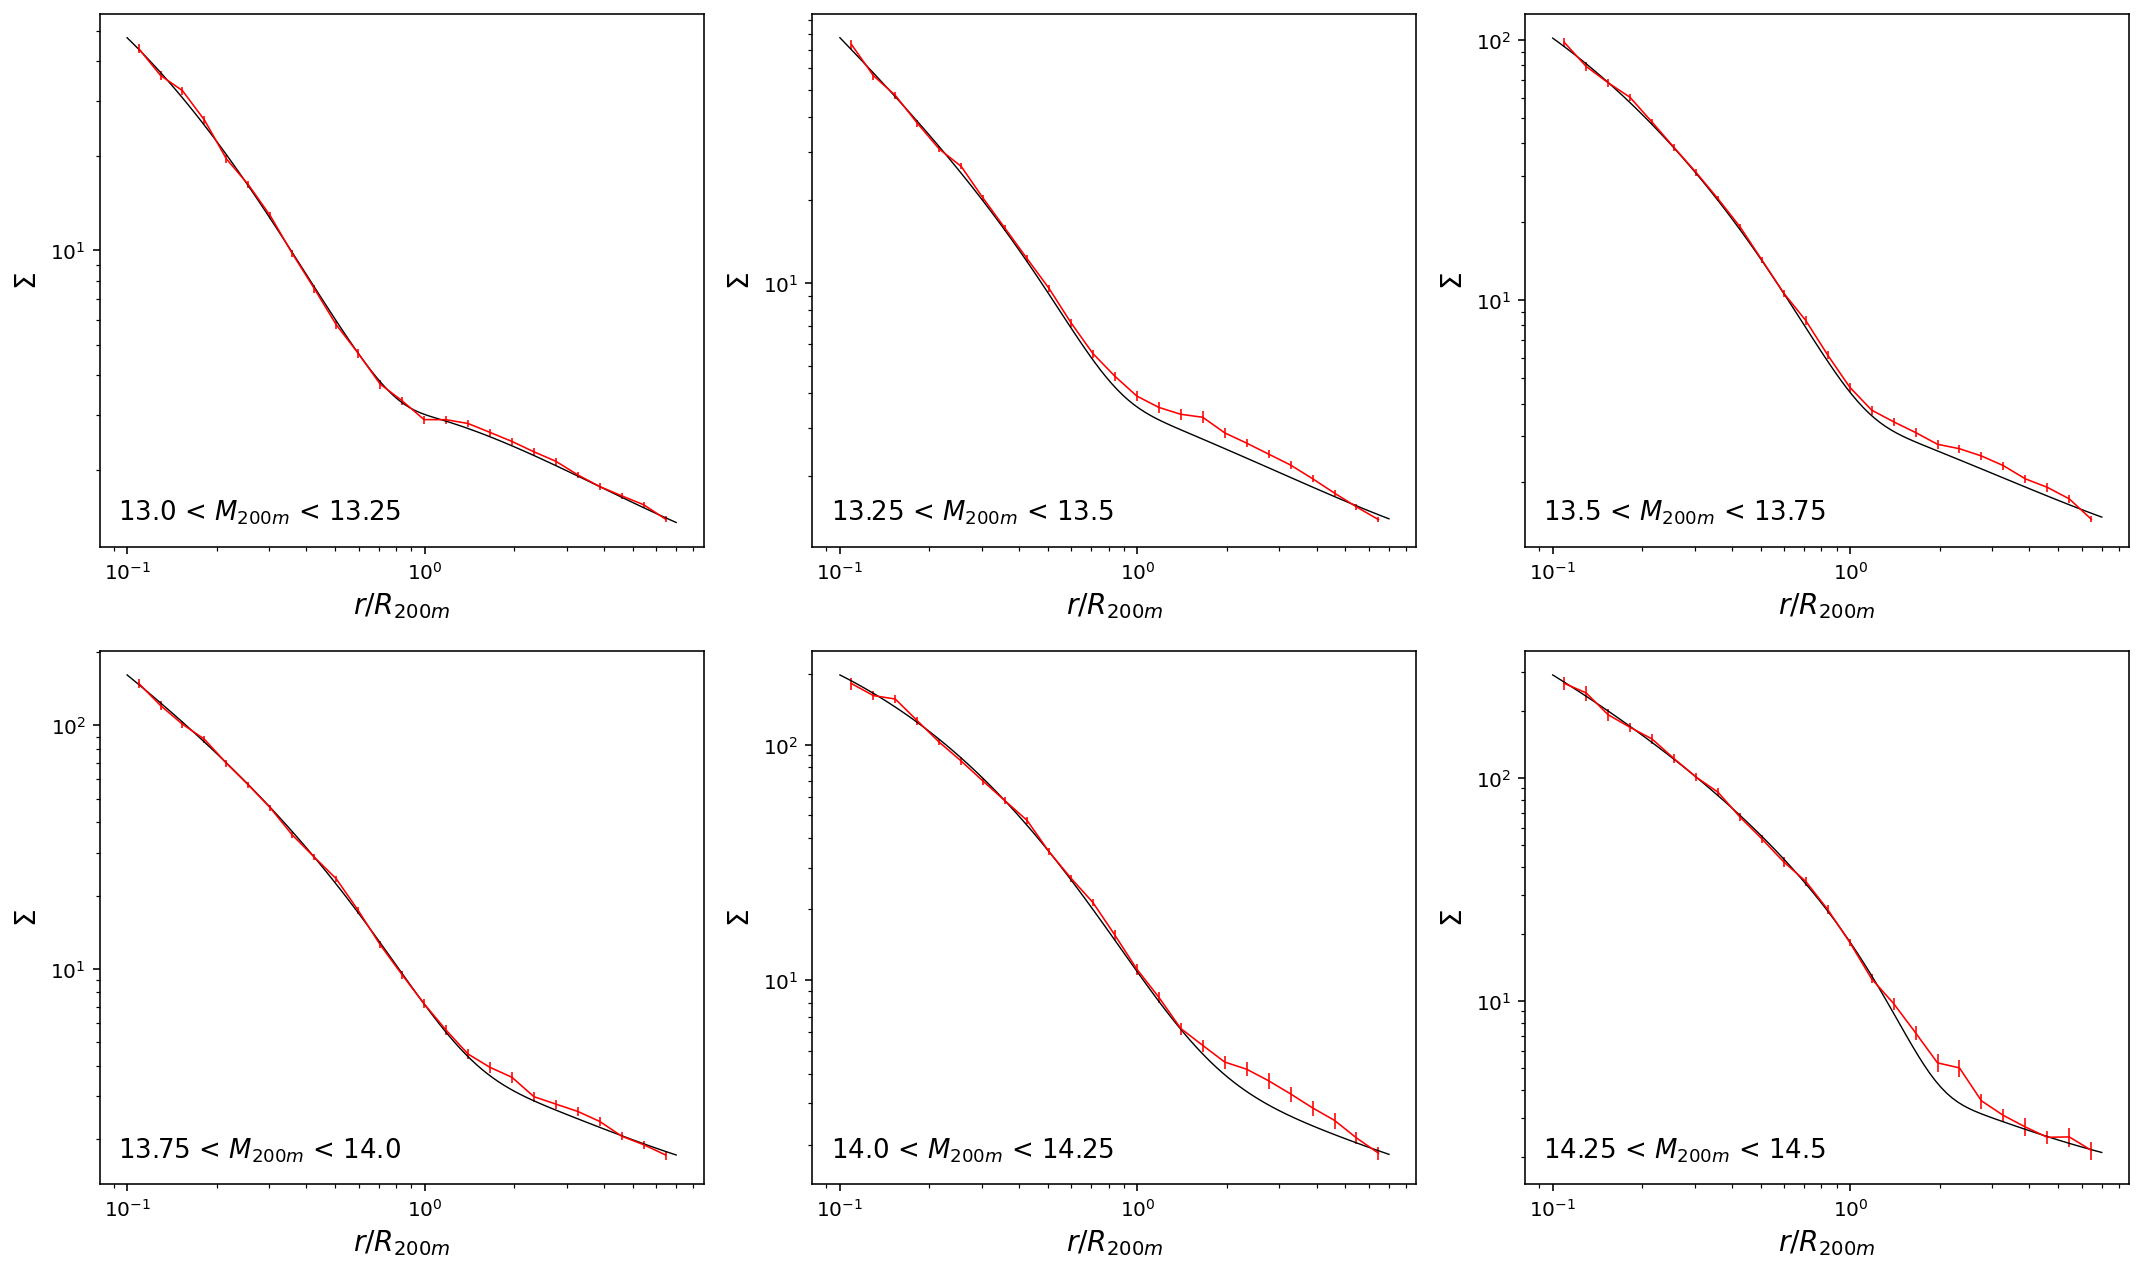

In [13]:
r_thr = np.logspace(-1, np.log10(7), 100)

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15,9)

for ax, mbin in zip(axs.flatten(), mbins):
    prof = mbin['prof']

    #Plot profile
    ax.errorbar(prof['r'], prof['dens'], yerr = np.sqrt(np.diag(prof['cov'])), color = 'r', linewidth = 0.8)

    #Set axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r"$\Sigma$", fontsize=14)
    ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)
    
    #Plot theory curves
    ax.plot(r_thr, fit_profs.sigma(fit_profs.rho_d22)(mbin['mle'], r_thr), color='k', linewidth=0.7)
    
    #Label
    ax.text(0.03, 0.05, mbin['bounds'], transform=ax.transAxes, fontsize=13)

plt.tight_layout()

##### **Determine splashback posterior**

We can then determine the splashback radius by looping through the samples in the chain and determining the location of minimum log derivative for each sample. I will only do this for one of the cluster mass bins for now

In [14]:
from tqdm import tqdm
import os
import joblib

if 'OMP_NUM_THREADS' in os.environ.keys():
    n_threads = int(os.environ['OMP_NUM_THREADS'])
else:
    n_threads = os.cpu_count()

#Radii at which log derivs are recorded for graphing
r_graph = np.logspace(-1, np.log10(7), 26)
#Radii at which log derivs are calculated and the minimum is taken for rsp calc
r_guess = np.logspace(-1, np.log10(7), 1000)

for mbin in mbins:
    chain = mbin['chain']
    samps = chain.samples['theta']
    n = chain.n_samp

    def get_log_derivs(ind):
        samp = samps[ind]
        return fit_profs.log_deriv_d22(samp, r_graph)
        
    def get_rsps(ind):
        samp = samps[ind]
        log_derivs = fit_profs.log_deriv_d22(samp, r_guess)
        return r_guess[np.argmin(log_derivs)]
    
    
    log_deriv = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_log_derivs)(i)
                                           for i in tqdm(range(n))))
    
    rsp = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_rsps)(i)
                                           for i in tqdm(range(n))))
    
    chain.add_samps(log_deriv = log_deriv, rsp = rsp)

100%|██████████████████████████████████████████████████████████████████████████| 10071/10071 [00:00<00:00, 21513.01it/s]


##### **Plot splashback posterior**

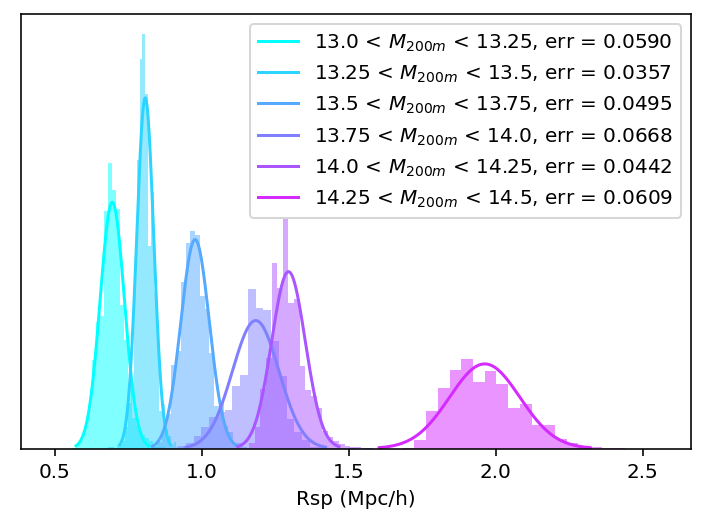

In [15]:
ax = plt.gca()
ax.set_xlabel("Rsp (Mpc/h)")
for mbin in mbins:
    chain = mbin['chain']
    chain.plot_1d_posterior('rsp', ax, label = f"{mbin['bounds']}, err = {chain.error('rsp'):.4f}", color = mbin['color'])


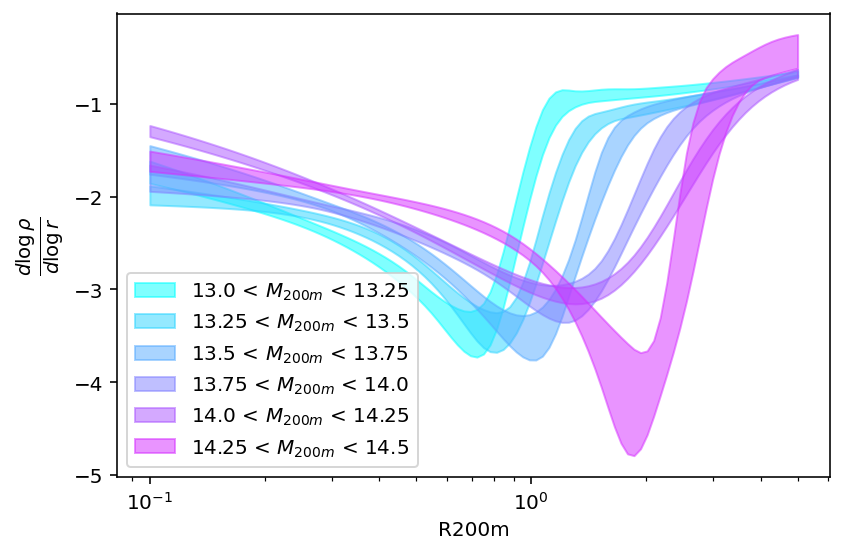

In [16]:
from scipy.interpolate import CubicSpline

def plot_log_deriv_processed(ax, chain, r_log_deriv, r_thr, **kwargs):
    """
    Plot smoothed density curve of splashback posterior
    """
    
    # Get 1 sigma interval on the derived chains
    
    mean, std = chain.get_samp_stats('log_deriv')
    lower_pts, upper_pts = mean - std, mean + std
    
    lower_spline = CubicSpline(r_log_deriv, lower_pts)
    upper_spline = CubicSpline(r_log_deriv, upper_pts)
    
    ax.fill_between(r_thr, lower_spline(r_thr), upper_spline(r_thr), alpha=0.5, **kwargs)
    ax.set_xscale('log')

r_thr = np.logspace(-1, np.log10(5), 100)
# Unstacked
# # Initialize Figure   
# fig, axs = plt.subplots(2, 3)
# fig.set_size_inches(15, 8)

# # Plot subplots and set axis label

# for mbin, ax in zip(mbins, axs.flatten()):
#     ax.set_xlabel(r"$r/R_{200m}$", fontsize=14)
#     ax.set_ylabel(r"$d\log\rho/d\log r$", fontsize=14)
    
#     plot_log_deriv_processed(ax, mbin['chain'], r_graph, r_thr)
    
# Stacked
ax = plt.gca()
ax.set_xlabel("R200m")
ax.set_ylabel(r"$\frac{d\log\rho}{d\log r}$", fontsize = 14)
for mbin in mbins:
    plot_log_deriv_processed(ax, mbin['chain'], r_graph, r_thr, label = mbin['bounds'], color = mbin['color'])
    ax.legend(loc = 3)
    
plt.tight_layout()

Text(0.5, 0, 'M200m ($M_\\odot$)')

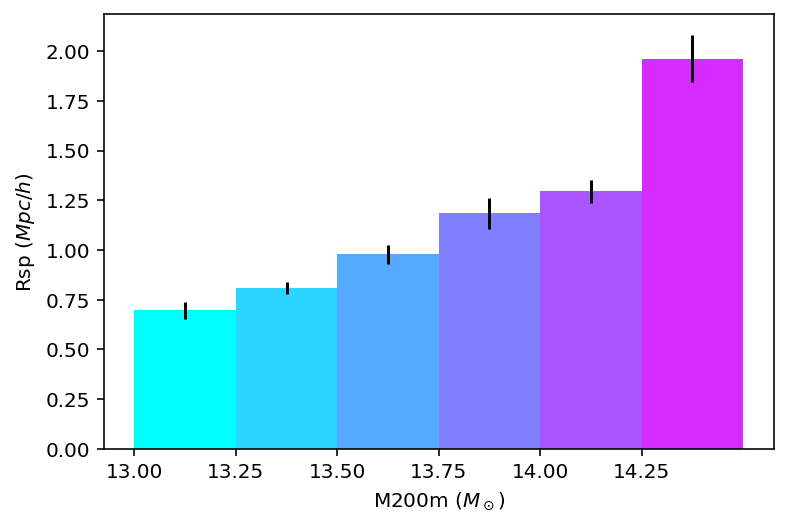

In [17]:
#As bar chart
ax = plt.gca()
rsp, rsp_err = zip(*[mbin['chain'].get_samp_stats('rsp') for mbin in mbins])
x = [f"{edge:.2f}" for edge in lg_edges[:-1]]
color = [mbin['color'] for mbin in mbins]
ax.bar(x, rsp, yerr = rsp_err, align = 'edge', color = color, width = 1)
ax.set_ylabel("Rsp ($Mpc/h$)")
ax.set_xlabel(r"M200m ($M_\odot$)")

# Splashback mass

## Sketchy Error Propagation

In [18]:
# from colossus.halo import profile_diemer22, concentration
# from colossus.cosmology import cosmology
# cosmology.setCosmology('planck18')
# def get_msp_posterior(mbin):
#     M200m_arr = mbin['clusters']['M200m']
#     mean_M200m = np.mean(M200m_arr)
#     std_M200m = np.std(M200m_arr)
#     M200m_interval = [mean_M200m, mean_M200m - std_M200m, mean_M200m + std_M200m]
#     mean_rsp, std_rsp = mbin['chain'].get_samp_stats('rsp')
#     rsp_interval = [mean_rsp, mean_rsp - std_rsp, mean_rsp + std_rsp]

#     def get_msp(M200m, rsp):
#         c, _ = concentration.modelBhattacharya13(M = M200m, z = redshift, mdef = '200m')
#         prof = profile_diemer22.ModelAProfile(M = M200m, c = c, mdef = '200m', z = redshift)
#         return prof.enclosedMass(rsp * 1000)
    
#     res = [get_msp(M200m, rsp) for M200m, rsp in zip(M200m_interval, rsp_interval)]
#     mbin['msp_mean'], mbin['msp_low'], mbin['msp_high'] = res
    
#     return res

# for mbin in mbins:
#     get_msp_posterior(mbin)

In [19]:
# msp_mean, msp_low, msp_high = np.array([(mbin['msp_mean'], mbin['msp_low'], mbin['msp_high']) for mbin in mbins]).T
# for mbin in mbins:
#     mbin['rsp'], _ = mbin['chain'].get_samp_stats('rsp')
# rsps = [mbin['rsp'] for mbin in mbins]

# ax = plt.gca()
# ax.errorbar(x = rsps, y = msp_mean, yerr = (msp_low, msp_high))
# ax.set_xlabel("Rsp")
# ax.set_ylabel("Splashback Mass")

## Mean M200m

In [20]:
from colossus.halo import profile_diemer22, concentration
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

def get_msp_posterior(mbin):
    M200m = np.mean(mbin['clusters']['M200m'])
    c, _ = concentration.modelBhattacharya13(M = M200m, z = redshift, mdef = '200m')
    prof = profile_diemer22.ModelAProfile(M = M200m, c = c, mdef = '200m', z = redshift)
    
    chain = mbin['chain']
    rsps = chain.samples['rsp'] * 1000
    
    def mass_prof_ind(ind):
        return prof.enclosedMass(rsps[ind])
    
    msps = joblib.Parallel(n_threads)(joblib.delayed(mass_prof_ind)(i)
                                       for i in tqdm(range(len(rsps))))
    chain.add_samps(msp = np.array(msps))
    return msps
    
for mbin in mbins:
    get_msp_posterior(mbin)

Deleted outdated persistence file, no further action needed.


100%|███████████████████████████████████████████████████████████████████████████| 10071/10071 [00:07<00:00, 1417.18it/s]


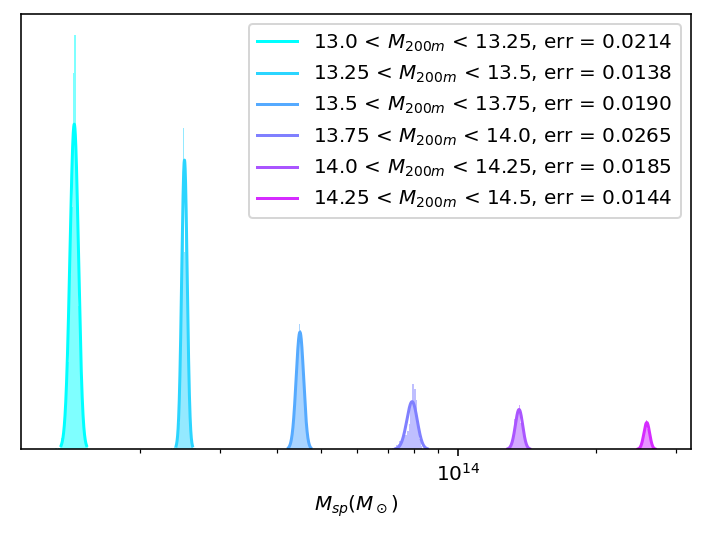

In [21]:
# fig, axs = plt.subplots(3, 2)
# fig.set_size_inches(9, 15)
# for ax, mbin in zip(axs.flatten(), mbins):
#     chain = mbin['chain']
#     mean, std = chain.get_samp_stats('msp')
#     chain.plot_1d_posterior('msp', ax, label = f"{mbin['bounds']}, err = {std/mean:.4f}" , color = mbin['color'])
ax = plt.gca()
ax.set_xlabel(r'$M_{sp} (M_\odot)$')
ax.set_xscale('log')
for mbin in mbins:
    chain = mbin['chain']
    mean, std = chain.get_samp_stats('msp')
    chain.plot_1d_posterior('msp', ax, label = f"{mbin['bounds']}, err = {std/mean:.4f}" , color = mbin['color'])
plt.savefig("Msp_post.png", facecolor = 'w')

Text(0, 0.5, '$M_{sp} (M_\\odot)$')

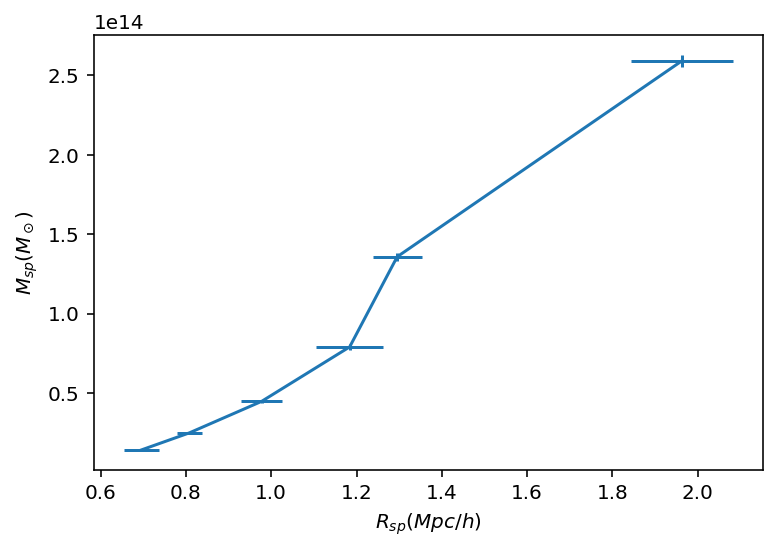

In [22]:
rsp = []
msp = []
msp_err = []
rsp_err = []
for mbin in mbins:
    chain = mbin['chain']
    rsp_i, rsp_err_i = chain.get_samp_stats('rsp')
    msp_i, msp_err_i = chain.get_samp_stats('msp')
    rsp.append(rsp_i)
    msp.append(msp_i)
    msp_err.append(msp_err_i)
    rsp_err.append(rsp_err_i)
ax = plt.gca()
ax.errorbar(x = rsp, xerr = rsp_err, y = msp, yerr = msp_err)
ax.set_xlabel('$R_{sp} (Mpc/h)$')
ax.set_ylabel('$M_{sp} (M_\odot)$')

In [33]:
for mbin in mbins:
    mean_M200m = np.mean(mbin['clusters']['M200m'])
    mean_msp, _ = mbin['chain'].get_samp_stats('msp')
    print((mean_M200m - mean_msp)/mean_msp)

-8.292890721872084e-02
-0.06908416737067394
-0.06623241858620325
-0.0650467949121505
-0.02462039650128075
-0.09296098864735797


## Accounting for M200m Spread

In [31]:
# from colossus.halo import profile_diemer22, concentration
# from colossus.cosmology import cosmology
# cosmology.setCosmology('planck18')

# def get_msp_posterior(mbin):
#     clusters = mbin['clusters']
    
#     #Generate profile
#     M200m = clusters['M200m']
#     c, _ = concentration.modelBhattacharya13(M = M200m, z = redshift, mdef = '200m')
    
#     def mass_prof_ind(ind):
#         try:
#             prof = profile_diemer22.ModelAProfile(M = M200m[ind], c = c[ind], mdef = '200m', z = redshift)
#         except:
#             cosmology.setCosmology('planck18')
#             prof = profile_diemer22.ModelAProfile(M = M200m[ind], c = c[ind], mdef = '200m', z = redshift)
#         return prof
    
#     mass_profs = joblib.Parallel(n_threads)(joblib.delayed(mass_prof_ind)(i)
#                                        for i in tqdm(range(len(c))))
    
#     print("Mass profs calculated, now generating msps")
    
#     chain = mbin['chain']
#     rsps = chain.samples['rsp'] * 1000
    
#     def get_msps_ind(ind):
#         prof = mass_profs[i]
#         return np.array([prof.enclosedMass(rsp_i) for rsp_i in rsps])
    
#     msps = np.array(joblib.Parallel(n_threads)(joblib.delayed(get_msps_ind)(i)
#                                        for i in tqdm(range(len(mass_profs)))))
#     print(chain.n_samp, rsps.shape, msps.shape)
    
#     msps = np.apply_along_axis(np.mean, 0, msps)
    
#     chain.add_samps(msp = msps)

#     return msps
    
# for mbin in mbins:
#     get_msp_posterior(mbin)

Deleted outdated persistence file, no further action needed.


100%|██████████████████████████████████████████████████████████████████████████████| 1594/1594 [00:01<00:00, 887.21it/s]


Mass profs calculated, now generating msps


 12%|█████████▍                                                                    | 192/1594 [30:29<4:00:12, 10.28s/it]

KeyboardInterrupt: 

## Plot Splashback Mass Posteriors

In [24]:
np.savez('splashback_mass_chart', rsp = rsp, rsp_err = rsp_err, msp = msp, msp_err = msp_err)